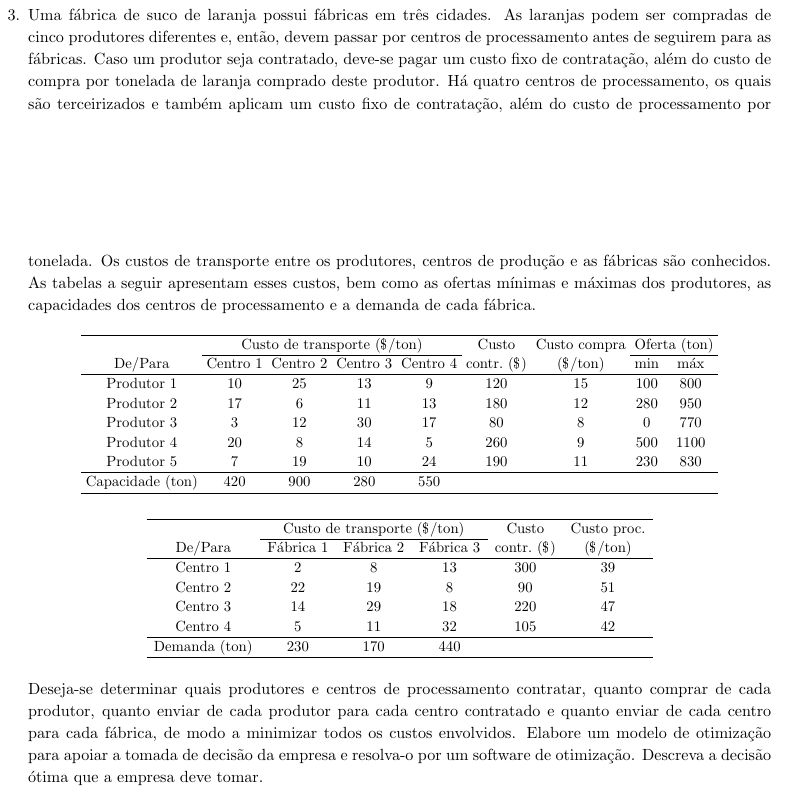

In [1]:
from IPython.display import Image
Image(filename='images/3.png')

In [8]:
# Dados
# Conjuntos
Produtores = [1, 2, 3, 4, 5]
Centros = [1, 2, 3, 4]
Fabricas = [1, 2, 3]
# Parâmetros
custo_contr_P = {1: 120, 2: 180, 3: 80, 4: 260, 5: 190}
custo_comp_P = {1: 15, 2: 12, 3: 8, 4: 9, 5: 11}
oferta_min_P = {1: 100, 2: 280, 3: 0, 4: 500, 5: 230}
oferta_max_P = {1: 800, 2: 950, 3: 770, 4: 1100, 5: 830}
custo_contr_C = {1: 300, 2: 90, 3: 220, 4: 105}
custo_proc_C = {1: 39, 2: 51, 3: 47, 4: 42}
capacidade_C = {1: 420, 2: 900, 3: 280, 4: 550}
demanda_F = {1: 230, 2: 170, 3: 440}

custo_P_C = {(1, 1): 10, (1, 2): 25, (1, 3): 13, (1,4): 9,
             (2, 1): 17, (2, 2): 6, (2, 3): 11, (2,4): 13,
             (3, 1): 3, (3, 2): 12, (3, 3): 30, (3,4): 17,
             (4, 1): 20, (4, 2): 8, (4, 3): 14, (4,4): 5,
             (5, 1): 7, (5, 2): 19, (5, 3): 10, (5,4): 24}

custo_C_F = {(1, 1): 2, (1, 2): 8, (1, 3): 13,
             (2, 1): 22, (2, 2): 19, (2, 3): 8,
             (3, 1): 14, (3, 2): 29, (3, 3): 18,
             (4, 1): 5, (4, 2): 11, (4, 3): 32}

In [9]:
# Módulos
from pyomo.environ import *
from pyomo.opt import SolverFactory

In [10]:
# Modelo
model = ConcreteModel()

# Conjuntos
model.P = Set(initialize=Produtores)
model.C = Set(initialize=Centros)
model.F = Set(initialize=Fabricas)
P, C, F = model.P, model.C, model.F

# Parâmetros
model.a = Param(P, initialize=custo_contr_P, within=NonNegativeReals)
model.b = Param(P, initialize=custo_comp_P, within=NonNegativeReals)
model.l = Param(P, initialize=oferta_min_P, within=NonNegativeReals)
model.u = Param(P, initialize=oferta_max_P, within=NonNegativeReals)
model.g = Param(C, initialize=custo_contr_C, within=NonNegativeReals)
model.h = Param(C, initialize=custo_proc_C, within=NonNegativeReals)
model.e = Param(C, initialize=capacidade_C, within=NonNegativeReals)
model.d = Param(F, initialize=demanda_F, within=NonNegativeReals)
model.c = Param(P * C, initialize=custo_P_C, within=NonNegativeReals)
model.t = Param(C * F, initialize=custo_C_F, within=NonNegativeReals)
a, b, l, u, g, h, e, d, c, t = (model.a, model.b, model.l, model.u, model.g, 
                                model.h, model.e, model.d, model.c, model.t)

# Variáveis de decisão
model.q = Var(P, within=NonNegativeReals)
model.p = Var(C, within=NonNegativeReals)
model.v = Var(P * C, within=NonNegativeReals)
model.w = Var(C * F, within=NonNegativeReals)
model.y = Var(P, within=Binary)
model.z = Var(C, within=Binary)
q, p, v, w, y, z = model.q, model.p, model.v, model.w, model.y, model.z

# Função objetivo
model.obj = Objective(sense=minimize,
                      expr = (sum(a[i]*y[i] + b[i]*q[i] for i in P) +
                              sum(g[j]*z[j] + h[j]*p[j] for j in C) + 
                              sum(sum(c[i,j]*v[i,j] for i in P) for j in C) +
                              sum(sum(t[j,k]*w[j,k] for j in C) for k in F)))

# Restrições
# Oferta do produtor
model.r_oferta_P = ConstraintList()
for i in P:
    model.r_oferta_P.add(expr = q[i] >= l[i] * y[i])
    model.r_oferta_P.add(expr = q[i] <= u[i] * y[i])
# Capacidade do centro de processamento
model.r_capacidade_C = ConstraintList()
for j in C:
    model.r_capacidade_C.add(expr = sum(v[i,j] for i in P) <= e[j])
# Demanda da fábrica
model.r_demanda_F = ConstraintList()
for k in F:
    model.r_demanda_F.add(expr = sum(w[j,k] for j in C) >= d[k])
# Necessidade de compra
model.r_compra = ConstraintList()
for i in P:
    model.r_compra.add(expr = sum(v[i,j] for j in C) == q[i])
# Entra = Sai
model.r_balanco = ConstraintList()
for j in C:
    model.r_balanco.add(expr = sum(v[i,j] for i in P) == sum(w[j,k] for k in F))
# Quantidade processada
model.r_processamento = ConstraintList()
for j in C:
    model.r_processamento.add(expr = sum(v[i,j] for i in P) == p[j])
# Variável de contratação do centro de processamento
model.r_contr_C = ConstraintList()
for j in C:
    model.r_contr_C.add(expr = p[j] <= 10000*z[j])
    
# model.pprint()

In [11]:
# Resolução
solver = SolverFactory('glpk')
resultado = solver.solve(model, tee=False)

In [14]:
# Apresentação de resultados
if (resultado.solver.status == SolverStatus.ok) and (resultado.solver.termination_condition != TerminationCondition.infeasible):
    print('  1. Decisões de compra: \n')
    for i in P:
        print('Laranja comprada do produtor {}: {:.3f} ton.'.format(i, value(q[i])))
        print('Binário de contratação do fornecedor {}: {} \n'.format(i, value(y[i])))
    print('  2. Decisões de processamento: \n')
    for j in C:
        print('Laranja processada no centro {}: {:.3f} ton.'.format(j, value(p[j])))
        print('Binário de contratação do centro {}: {} \n'.format(j, value(z[j])))
    print('  3. Logística de produtores e centros: \n')
    for i in P:
        for j in C:
            print('Quantidade enviada do produtor {} ao centro {}: {:.3f} ton.'.format(i, j, value(v[i,j])))
        print()
    print('  4. Logística de centros e fábricas: \n')
    for j in C:
        for k in F:
            print('Quantidade enviada do centro {} à fábrica {}: {:.3f} ton.'.format(j, k, value(w[j,k])))
        print()
else:
    print(resultado.solver.termination_condition)

print('  Função objetivo:\n')
print('O custo mínimo obtido foi de ${:.2f}'.format(value(model.obj)))

  1. Decisões de compra: 

Laranja comprada do produtor 1: 0.000 ton.
Binário de contratação do fornecedor 1: 0.0 

Laranja comprada do produtor 2: 0.000 ton.
Binário de contratação do fornecedor 2: 0.0 

Laranja comprada do produtor 3: 340.000 ton.
Binário de contratação do fornecedor 3: 1.0 

Laranja comprada do produtor 4: 500.000 ton.
Binário de contratação do fornecedor 4: 1.0 

Laranja comprada do produtor 5: 0.000 ton.
Binário de contratação do fornecedor 5: 0.0 

  2. Decisões de processamento: 

Laranja processada no centro 1: 340.000 ton.
Binário de contratação do centro 1: 1.0 

Laranja processada no centro 2: 100.000 ton.
Binário de contratação do centro 2: 1.0 

Laranja processada no centro 3: 0.000 ton.
Binário de contratação do centro 3: 0.0 

Laranja processada no centro 4: 400.000 ton.
Binário de contratação do centro 4: 1.0 

  3. Logística de produtores e centros: 

Quantidade enviada do produtor 1 ao centro 1: 0.000 ton.
Quantidade enviada do produtor 1 ao centro 2: